In [1]:
import argparse
import os
os.umask(0)
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

os.environ["CUDA_VISIBLE_DEVICES"] = "0，1，2，3"

import pickle
import sys
from importlib import import_module

import torch
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm

from data import InteDataset
from data import ArgoTestDataset
from utils import Logger, load_pretrain
from shapely.geometry import Polygon

import numpy as np

# define parser
parser = argparse.ArgumentParser(description="Argoverse Motion Forecasting in Pytorch")
parser.add_argument(
    "-m", "--model", default="lanegcn", type=str, metavar="MODEL", help="model name"
)
parser.add_argument("--eval", action="store_true", default=True)
parser.add_argument(
    "--split", type=str, default="val", help='data split, "val" or "test"'
)
parser.add_argument(
    "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
)
# parser.add_argument(
#     "--weight", default="/media/drl/datas/zyk/LaneGCN/results/lanegcn/17.000.ckpt", type=str, metavar="WEIGHT", help="checkpoint path"
# )


_StoreAction(option_strings=['--weight'], dest='weight', nargs=None, const=None, default='/media/drl/datas/zyk/LaneGCN/results/lanegcn_interaction/36.000.ckpt', type=<class 'str'>, choices=None, help='checkpoint path', metavar='WEIGHT')

In [2]:
root_path = '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified'
sys.path.insert(0, root_path)

model = import_module("lanegcn")
config, _, collate_fn, net, loss, post_process, opt = model.get_model()


In [3]:
config

{'display_iters': 79872,
 'val_iters': 79872,
 'save_freq': 0.1,
 'epoch': 0,
 'horovod': True,
 'opt': 'adam',
 'num_epochs': 80,
 'lr': [0.001, 0.0001],
 'lr_epochs': [32],
 'lr_func': <utils.StepLR at 0x7fd9306bbe90>,
 'save_dir': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/results/lanegcn',
 'batch_size': 16,
 'val_batch_size': 16,
 'workers': 0,
 'val_workers': 0,
 'train_split': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/train/data',
 'val_split': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/val/data',
 'test_split': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/test_obs/data',
 'preprocess': True,
 'preprocess_train': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/preprocess/val_crs_dist6_angle90.p',
 'preprocess_val': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/preprocess/val_crs_dist6_angle90.p',
 'preprocess_test': '/home/user/Backup/DRL服务器备份/Projects/LaneGCN_modified/dataset/prepro

In [5]:
## 10s multi LL
ckpt_path = "/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_for_training_EEMG/results_multi_ll/80.000.ckpt"

## 10s single LL
# ckpt_path = "/home/user/Projects/interaction_gyt/preprocess_results_10s_for_training_EEMG/results_0812/41.000.ckpt"

## 10s GCN
# ckpt_path = "/home/user/Datasets/interpolated/preprocess_results_10s_interp10scale8/results/47.000.ckpt"

## 5s multi LL
# ckpt_path = "/home/user/Projects/interaction_gyt/preprocess_results_5s_for_training_EEGM/results_multi_ll/17.000.ckpt"

## 5s single LL
# ckpt_path = "/home/user/Projects/interaction_gyt/preprocess_results_5s_for_training_EEGM/results_single_ll/12.000.ckpt"

## 5s GCN
# ckpt_path = "/home/user/Projects/LaneGCN_modified/results/history_results/raw_map_results/lanegcn_5s/36.000.ckpt"


if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()


with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'EP0_all_940_1070_950_1040_mask.pkl'), 'rb') as f:
    img_EP0 = pickle.load(f, encoding="latin1")
    EP0_bds = (940, 1070, 950, 1040)
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'EP1_all_942_1115_949_1032_mask.pkl'), 'rb') as f:
    img_EP1 = pickle.load(f, encoding="latin1")
    EP1_bds = (942, 1115, 949, 1032)
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'GL_all_920_1040_940_1025_mask.pkl'), 'rb') as f:
    img_GL = pickle.load(f, encoding="latin1")
    GL_bds = (920, 1040, 940, 1025)
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0914", 'MA_all_970_1080_960_1050_mask.pkl'), 'rb') as f:
    img_MA = pickle.load(f, encoding="latin1")
    MA_bds = (970, 1080, 960, 1050)

In [14]:
# 生成RL所需轨迹

## 10s test
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_10s_for_testing_EP0/test/'

## 10s csv
# filepath = '/home/user/Backup/DRL服务器备份/Projects/interaction_gyt/preprocess_results_10s_use_csv_EP0_with_agtid_final/test'
filepath = '/home/user/Backup/DRL服务器备份/Logs/1801/FT_SCR_py3/'

## 5s test
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_5s_for_testing_EP0/test/'

## 5s csv
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_5s_use_csv_EP0/test/'

# 10s fake
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_10s_for_testing_fake_EP0/test'

# 10 EEMG
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_10s_for_testing_EEMG/test'

# 5 EEMG
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_5s_for_training_EEGM/test'



dataset = InteDataset(filepath)
# dataset = InteDataset('/home/user/Datasets/raw_map/preprocess_results_5s/tmp/')
data_loader = DataLoader(
    dataset,
    batch_size=config["val_batch_size"],
    num_workers=config["val_workers"],
    collate_fn=collate_fn,
    shuffle=False,
    pin_memory=False,
)

# begin inference
preds = {}
gts = {}
cities = {}

data_list = []
off_road_count = 0
total_count = 0
k = 0

first_total_count = 0
first_off_road_count = 0

collision_trajs_count = 0
first_collision_trajs_count = 0

map_collision = {
    "P0": [0, 0, 0, 0],
    "P1": [0, 0, 0, 0],
    "GL": [0, 0, 0, 0],
    "MA": [0, 0, 0, 0]
}

max_acc_rcd, min_acc_rcd = [], []
all_beta_rcd, max_beta_rcd = [], []

cC, cR, cA = 0,0,0
cRC, cRA, cCA = 0,0,0
cRCA = 0

for ii, data in tqdm(enumerate(data_loader)):
    data = dict(data)
    with torch.no_grad():
        
        output = net(data)
        loss_out = loss(output, data)
        results = [x.detach().cpu().numpy() for x in output["reg"]]

        for idx in range(len(results)):
            filename = data['filename'][idx].split('/')[-1]
            with open(os.path.join(filepath, filename), 'rb') as f:
                origin_data = pickle.load(f, encoding="latin1")

            if filename[-6:-4] == "P0":
                use_img = img_EP0
                min_x, max_x, min_y, max_y = EP0_bds
            elif filename[-6:-4] == "P1":
                use_img = img_EP1    
                min_x, max_x, min_y, max_y = EP1_bds
            elif filename[-6:-4] == "GL":
                use_img = img_GL
                min_x, max_x, min_y, max_y = GL_bds
            else:
                use_img = img_MA
                min_x, max_x, min_y, max_y = MA_bds
            
            for k in range(1):
                new_data = {}
#                 ego_id = origin_data['idx']
                new_data['egos_track'] = {}
                for a in range(origin_data['shapes'].shape[0]):
                    ego_id = origin_data['agt_ids'][a]
                    traj_xyphi, traj_interval_vel = interval(data, results, idx, a, k)
                    if traj_interval_vel.shape[0] < 2:
                        print("too short! idx ", idx, 'traj ', traj_interval_vel)
                        continue
                    new_data['egos_track'][ego_id] = [[filename.split('_')[1], filename.split('_')[2]]] + traj_interval_vel[:, [0,1,3]].tolist()


                new_data['others_track'] = {}
                new_data['gt_of_acc_violation'] = {}
                new_data['gt_of_rotation'] = {}
                start_time = int(filename.split('_')[1])
                end_time = int(filename.split('_')[2])
                
#                 if origin_data['shapes'].shape[0] != 2:
#                     print("not 2! ", data['filename'][idx], origin_data['shapes'].shape[0])
                for a in range(origin_data['shapes'].shape[0]):
                    other_id = origin_data['agt_ids'][a]
                    new_data['others_track'][other_id] = [origin_data['shapes'][a].tolist() + [start_time, end_time]]


                    traj_xyphi, traj_interval_vel = interval(data, results, idx, a, k)
                    origin_yaw = traj_interval_vel[0, 2] % (2 * np.pi)

#                     if np.pi / 4 <= origin_yaw and origin_yaw < np.pi * 3 / 4:
#                         use_img = img_from_bot
#                         tag = "bot"
#                     elif np.pi * 3 / 4 <= origin_yaw and origin_yaw < np.pi * 5 / 4:
#                         use_img = img_from_right
#                         tag = "right"
#                     elif np.pi * 5 / 4 <= origin_yaw and origin_yaw < np.pi * 7 / 4:
#                         use_img = img_from_up
#                         tag = "up"
#                     else:
#                         use_img = img_from_left 
#                         tag = "left"


                    flag_off_road = False
#                     use_img = img_all
                    
                    use_ground_truth = False
                    max_acc = float('-inf')
                    min_acc = float('inf')
                    max_beta = 0
                
                    tmp_traj = np.concatenate([data['gt_hist'][idx][a][:, :2], data['gt_preds'][idx][a]], axis=0)
#                     tmp_traj = np.concatenate([data['gt_hist'][idx][a][:, :2], results[idx][a][0]], axis=0)
                    for ttt in range(traj_xyphi.shape[0]):
                        if ttt > 1:
                            if use_ground_truth:
                                dx0, dy0 = tmp_traj[ttt][0] - tmp_traj[ttt-1][0], tmp_traj[ttt][1] - tmp_traj[ttt-1][1]
                                cur_v = np.sqrt(dx0 ** 2 + dy0 ** 2) * 10
                                cur_yaw = math.atan2(dy0, dx0)
                                
                                dx1, dy1 = tmp_traj[ttt-1][0] - tmp_traj[ttt-2][0], tmp_traj[ttt-1][1] - tmp_traj[ttt-2][1]
                                last_v = np.sqrt(dx1 ** 2 + dy1 ** 2) * 10
                                last_yaw = math.atan2(dy1, dx1)
                            else:
                                cur_v = np.sqrt(traj_xyphi[ttt][3] ** 2 + traj_xyphi[ttt][4] ** 2)
                                last_v = np.sqrt(traj_xyphi[ttt-1][3] ** 2 + traj_xyphi[ttt-1][4] ** 2)                            
                                cur_yaw = traj_xyphi[ttt][2]
                                last_yaw = traj_xyphi[ttt-1][2]
                                
                            beta = min((cur_yaw - last_yaw) % 6.28, (last_yaw - cur_yaw) % 6.28)
                            all_beta_rcd.append(beta)
                            max_beta = max(max_beta, beta)
                            
                            acc = (cur_v - last_v) * 10
                            max_acc = max(max_acc, acc)
                            min_acc = min(min_acc, acc)
                        
                        timestamp = start_time + ttt * 100
                        x, y, phi, vx, vy = traj_xyphi[ttt]
                        addinfo = [timestamp, x, y, vx, vy, phi]
                        new_data['others_track'][other_id].append(addinfo)


#                         if x < min_x or x > max_x or y < min_y or y > max_y:
#                         # 正常行驶至道路末端
# #                         if x < 943 or x > 1065 or y < 958 or y > 1028: 
#                             continue
            
#                         grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
# #                         grid_x, grid_y = int((max_x - min_x) * 10 * (x - min_x) / (max_x - min_x + 1)), int((max_y - min_y) * 10 * (max_y - y) / (max_y - min_y + 1))
#                         if use_img[grid_y, grid_x] != 0:
# #                             print("tag from %s agt %d fail at time %d, pos %f, %f, value %d" %(tag, a, ttt, x, y, use_img[grid_y, grid_x]))
#                             flag_off_road = True
                    
                    if True:
                        other_id = origin_data['agt_ids'][a]
                        new_data['gt_of_acc_violation'][other_id] = np.concatenate([data['gt_hist'][idx][a][:, :2], data['gt_preds'][idx][a]], axis=0)             
                
                    if max_beta > 3.0:
                        other_id = origin_data['agt_ids'][a]
                        new_data['gt_of_rotation'][other_id] = np.concatenate([data['gt_hist'][idx][a][:, :2], data['gt_preds'][idx][a]], axis=0)             
                
                    max_beta_rcd.append(max_beta)
                    max_acc_rcd.append(max_acc)
                    min_acc_rcd.append(min_acc)
                                        
                    total_count += 1
                    map_collision[filename[-6:-4]][1] += 1
                    if flag_off_road:
                        off_road_count += 1
                        map_collision[filename[-6:-4]][0] += 1
                        
                    if k == 0:
                        map_collision[filename[-6:-4]][3] += 1
                        first_total_count += 1
                        if flag_off_road:
                            first_off_road_count += 1
                            map_collision[filename[-6:-4]][2] += 1
                            
                            
                N = len(new_data['others_track'].keys())
                collision = np.zeros(N)
                
                for time_stamp in range(100):
                    polygon_coll = []
                    for a in new_data['others_track'].keys():
                        tmp = np.zeros([3])
                        tmp[0] = new_data['others_track'][a][1:][time_stamp][1]
                        tmp[1] = new_data['others_track'][a][1:][time_stamp][2]
                        tmp[2] = new_data['others_track'][a][1:][time_stamp][5]

#                         if a not in new_data['egos_track'].keys():
#                             tmp[0] = new_data['others_track'][a][1:][0][1]
#                             tmp[1] = new_data['others_track'][a][1:][0][2]
#                             tmp[2] = new_data['others_track'][a][1:][0][5]   
                            
                        width = new_data['others_track'][a][0][0]
                        length = new_data['others_track'][a][0][1]
                        ms = tmp
                        polygon_coll.append(Polygon(polygon_xy_from_motionstate(ms, width, length)))

                    for i in range(len(polygon_coll)):
                        p1 = polygon_coll[i]
                        for j in range(i+1, len(polygon_coll)):
                            p2 = polygon_coll[j]
                            
                            if(p1.intersects(p2)):
                                collision[i] = 1
                                collision[j] = 1
                collision_trajs_count += np.sum(collision)
                if k == 0:
                    first_collision_trajs_count += np.sum(collision)
    
                new_data['gt_of_collision'] = {}
                for a in range(origin_data['shapes'].shape[0]):
                    if collision[a] == 1:
                        other_id = origin_data['agt_ids'][a]
                        new_data['gt_of_collision'][other_id] = np.concatenate([data['gt_hist'][idx][a][:, :2], data['gt_preds'][idx][a]], axis=0)
    
                new_data['gt_of_trouble'] = {}
                for key in new_data['gt_of_collision'].keys():
                    new_data['gt_of_trouble'][key] = new_data['gt_of_collision'][key]
                
                for key in new_data['gt_of_acc_violation'].keys():
                    new_data['gt_of_trouble'][key] = new_data['gt_of_acc_violation'][key]
                
                for key in new_data['gt_of_rotation'].keys():
                    new_data['gt_of_trouble'][key] = new_data['gt_of_rotation'][key]
                
                for key in new_data['gt_of_trouble'].keys():
                    if key in new_data['gt_of_collision']:
                        cC += 1
                    if key in new_data['gt_of_rotation']:
                        cR += 1
                    if key in new_data['gt_of_acc_violation']:
                        cA += 1
                        
                    if key in new_data['gt_of_collision'] and key in new_data['gt_of_rotation']:
                        cRC += 1
                    if key in new_data['gt_of_acc_violation'] and key in new_data['gt_of_rotation']:
                        cRA += 1
                    if key in new_data['gt_of_collision'] and key in new_data['gt_of_acc_violation']:
                        cCA += 1
                    if key in new_data['gt_of_collision'] and key in new_data['gt_of_rotation'] and key in new_data['gt_of_acc_violation']:
                        cRCA += 1
                
#             if ii == 1:
#                 break

#         if ii == 1:
#             break

#             with open(os.path.join('/home/user/Projects/interaction_gyt/preprocess_results_10s_use_csv_EP0_with_agtid_final/test_0913_3', filename), 'wb') as f22:
#                 pickle.dump(new_data, f22, protocol=pickle.HIGHEST_PROTOCOL)
            with open(os.path.join('home/user/Backup/DRL服务器备份/Logs/1801/test_FT_SCR_py3', filename), 'wb') as f22:
                pickle.dump(new_data, f22, protocol=pickle.HIGHEST_PROTOCOL)


0it [00:00, ?it/s]


KeyError: 'feats'

In [19]:
print(cC, cR, cA, cRC, cRA, cCA, cRCA)
print(cRC, cRA, cCA, cRCA)

828 56 19 14 0 4 0
14 0 4 0


In [40]:
for key in map_collision.keys():
    A = map_collision[key]
    print(key, "total %f, first %f" %(A[0]/A[1], A[2]/A[3]))


P0 total 0.062829, first 0.062829


ZeroDivisionError: division by zero

0.03846754554632553

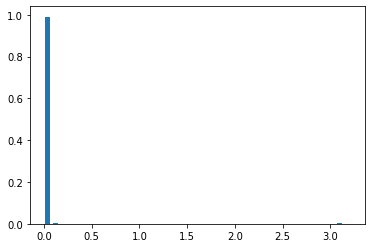

In [27]:
# prediction
tmp_N = 40
tmp = np.zeros(tmp_N + 1)
itv = (max(all_beta_rcd) - min(all_beta_rcd)) / tmp_N

bb = min(all_beta_rcd)
for beta in all_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)],  (tmp / len(all_beta_rcd)), width=2/tmp_N)

mean_beta = sum(all_beta_rcd) / len(all_beta_rcd)
np.sum((np.array(all_beta_rcd) - mean_beta) ** 2) / len(all_beta_rcd)

1.53358923937388

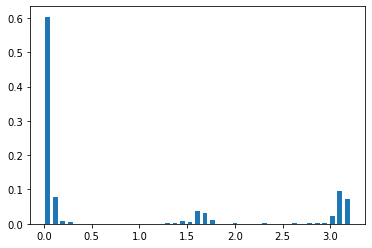

In [39]:

tmp = np.zeros(tmp_N + 1)
itv = (max(max_beta_rcd) - min(max_beta_rcd)) / tmp_N

bb = min(max_beta_rcd)
for beta in max_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)], tmp / len(max_beta_rcd), width=2/tmp_N)

mean_beta = sum(max_beta_rcd) / len(max_beta_rcd)
np.sum((np.array(max_beta_rcd) - mean_beta) ** 2) / len(max_beta_rcd)


In [ ]:
# ground truth
tmp_N = 40
tmp = np.zeros(tmp_N + 1)
itv = (max(all_beta_rcd) - min(all_beta_rcd)) / tmp_N

bb = min(all_beta_rcd)
for beta in all_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
# plt.plot([i * itv for i in range(tmp_N + 1)], 100 * tmp / len(max_acc_rcd))
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)], 100 * tmp / len(all_beta_rcd), width=2/tmp_N)


mean_beta = sum(all_beta_rcd) / len(all_beta_rcd)
np.sum((np.array(all_beta_rcd) - mean_beta) ** 2) / len(all_beta_rcd)

In [ ]:

tmp = np.zeros(tmp_N + 1)
itv = (max(max_beta_rcd) - min(max_beta_rcd)) / tmp_N

bb = min(max_beta_rcd)
for beta in max_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
# plt.plot([i * itv for i in range(tmp_N + 1)], 100 * tmp / len(max_acc_rcd))
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)], 100 * (tmp / len(max_beta_rcd)), width=2/tmp_N)

mean_beta = sum(max_beta_rcd) / len(max_beta_rcd)
np.sum((np.array(max_beta_rcd) - mean_beta) ** 2) / len(max_beta_rcd)

In [ ]:
# result
tmp_N = 40
tmp = np.zeros(tmp_N + 1)
itv = (max(all_beta_rcd) - min(all_beta_rcd)) / tmp_N

bb = min(all_beta_rcd)
for beta in all_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
# plt.plot([i * itv for i in range(tmp_N + 1)], 100 * tmp / len(max_acc_rcd))
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)], 100 * tmp / len(all_beta_rcd), width=2/tmp_N)


mean_beta = sum(all_beta_rcd) / len(all_beta_rcd)
np.sum((np.array(all_beta_rcd) - mean_beta) ** 2) / len(all_beta_rcd)

545

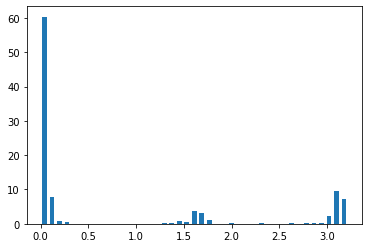

In [67]:

tmp = np.zeros(tmp_N + 1)
itv = (max(max_beta_rcd) - min(max_beta_rcd)) / tmp_N

bb = min(max_beta_rcd)
for beta in max_beta_rcd :
    tmp[int((beta - bb) // itv)] += 1
# plt.plot([i * itv for i in range(tmp_N + 1)], 100 * tmp / len(max_acc_rcd))
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)], 100 * (tmp / len(max_beta_rcd)), width=2/tmp_N)

mean_beta = sum(max_beta_rcd) / len(max_beta_rcd)
np.sum((np.array(max_beta_rcd) - mean_beta) ** 2) / len(max_beta_rcd)

np.sum(np.array(max_beta_rcd) >= 3.0)

In [ ]:
min_x, max_x, min_y, max_y

tmp_N = 40
tmp = np.zeros(tmp_N + 1)
itv = max(max_acc_rcd) / tmp_N

for acc in max_acc_rcd :
    tmp[int(acc // itv)] += 1
# plt.plot([i * itv for i in range(tmp_N + 1)], 100 * tmp / len(max_acc_rcd))
plt.bar([(i + 0.5) * itv for i in range(tmp_N + 1)], 100 * tmp / len(max_acc_rcd), width=4/tmp_N)
# max_acc_rcd

In [ ]:
max(min_acc_rcd)
tmp_N = 40
tmp = np.zeros(tmp_N + 1)
itv = abs(min(min_acc_rcd)) / tmp_N

for acc in min_acc_rcd :
    tmp[int(abs(acc) // itv)] += 1
plt.bar([(i + 0.5) * -itv for i in range(tmp_N + 1)], 100 * tmp / len(min_acc_rcd), width=4/tmp_N)
# min_acc_rcd

NameError: name 'max_acc_rcd' is not defined

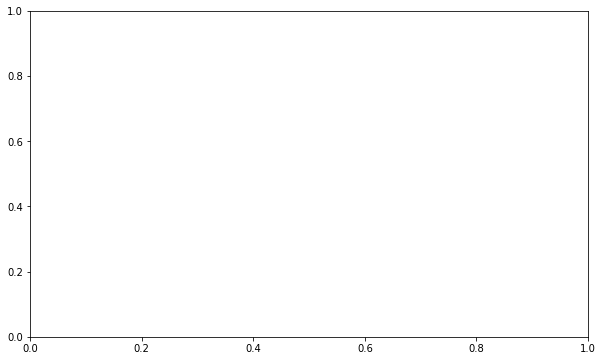

In [13]:
fig, ax = plt.subplots(1,1,figsize = [10,6])
tmp_N = 40 
tmp = np.zeros(tmp_N * 2 + 2)
itv = max(max(max_acc_rcd), -min(min_acc_rcd)) / tmp_N

for acc in min_acc_rcd :
    tmp[tmp_N - int(abs(acc) // itv)] += 1
    
for acc in max_acc_rcd :
    tmp[tmp_N + int(acc // itv)] += 1
    
font2 = {'family':'Times New Roman',
'size' : 25,
}
plt.tick_params(labelsize=25)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
    
plt.bar([(i - 40 + 0.5) * itv for i in range(tmp_N * 2 + 2)], 100 * tmp / len(max_acc_rcd), width=3.9/tmp_N)
plt.xlabel("Max acceleration m/s^2", font2)
plt.ylabel("Probability %", font2)
plt.savefig('/home/user/Logs/1102/acc', dpi=400)
# plt.title("acceleration distribution ", font2)

In [ ]:
new_data['others_track'] = {}
start_time = int(filename.split('_')[1])
end_time = int(filename.split('_')[2])
for iii in range(origin_data['shapes'].shape[0]):
    other_id = origin_data['agt_ids'][iii]
    new_data['others_track'][other_id] = [origin_data['shapes'][iii].tolist() + [start_time, end_time]]

    traj_xyphi, traj_interval_vel = interval(data, results, idx, iii, k)
    for ttt in range(100):
        timestamp = start_time + ttt * 100
        x, y, phi, vx, vy = traj_xyphi[ttt]
        addinfo = [timestamp, x, y, vx/10, vy/10, phi]
        new_data['others_track'][other_id].append(addinfo)
    print(iii, other_id, new_data['others_track'][other_id][1])

traj_xyphi, traj_interval_vel = interval(data, results, idx, 0, k)
traj_xyphi

In [ ]:
print(off_road_count)
print(total_count)
print(1.0 * off_road_count / total_count)


In [ ]:
print(first_off_road_count)
print(first_total_count)
print(1.0 * first_off_road_count / first_total_count)


In [19]:
# filepath = '/home/user/Projects/interaction_gyt/preprocess_results_10s_use_csv_EP0_with_agtid_final/test'
print(total_count)
print(first_total_count)
print(collision_trajs_count)
print(first_collision_trajs_count)
print(1.0 * collision_trajs_count / total_count)
print(1.0 * first_collision_trajs_count / first_total_count)

2849
2849
828.0
828.0
0.29062829062829065
0.29062829062829065


In [61]:
print(100.0 * off_road_count / total_count)
print(100.0 * first_off_road_count / first_total_count)
print(100.0 * collision_trajs_count / total_count)
print(100.0 * first_collision_trajs_count / first_total_count)

6.282906282906283
6.282906282906283
29.062829062829064
29.062829062829064


In [13]:
feats = data['feats'][idx]

fake_ctrs = np.array([45, 8, 1])
tmp_ctrs = torch.cat([data['ctrs'][idx], torch.tensor(fake_ctrs[:2], dtype=torch.float).reshape(1, -1)])

fake_theta = np.pi
# data['theta'].append(fake_theta)

fake_feat = [[50-(50-fake_ctrs[0])*i/20 , fake_ctrs[1] , 1] for i in range(20)]
fake_feat = torch.tensor(fake_feat, dtype=torch.float).reshape(1, 20, -1)
tmp_feats = torch.cat([data['feats'][idx], fake_feat])
# data['feats'][idx]

tmp_has_preds = torch.cat([data['has_preds'][idx], data['has_preds'][idx][-1].reshape(1, -1)])

fake_rot_ctrs = torch.tensor(fake_ctrs[:2], dtype=torch.float)
fake_gt_preds = torch.cat([fake_rot_ctrs.reshape(1, -1) for i in range(config['pred_size'])], 0)
fake_gt_preds = torch.matmul(fake_gt_preds, data['rot'][0]) + data['orig'][idx]
tmp_gt_preds = torch.cat([data['gt_preds'][idx], fake_gt_preds.reshape(1, -1, 2)])

                           
tmp_steps = torch.cat([data['steps'][idx], data['steps'][idx][-1].reshape(1, -1)])

data['has_preds'][idx] = tmp_has_preds
data['gt_preds'][idx] = tmp_gt_preds
data['feats'][idx] = tmp_feats
data['theta'].append(fake_theta)
data['ctrs'][idx] = tmp_ctrs

with torch.no_grad():
    data = dict(data)

    output = net(data)
    results = [x.detach().cpu().numpy() for x in output["reg"]]
    display = post_process(output, data)

NameError: name 'data' is not defined

In [13]:
def traj_plot(traj, rot, orig, ax=None, c="", s=[]):

    
    if isinstance(traj, torch.Tensor):
        traj = traj.numpy()
    rot = rot.numpy()
    orig = orig.numpy()
    
    centerline = np.array([traj[:, 0] - orig[0], traj[:, 1] - orig[1]]).T
#     print(centerline)
    centerline = np.matmul(rot, (centerline.reshape(-1, 2)).T).T

    if ax is not None:
        ax.plot(centerline[:, 0], centerline[:, 1], c, s)
        
    return centerline

def dis(x0, x1, y0, y1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2)


In [ ]:
data.keys()

In [ ]:
pred_traj = np.insert(results[idx][a, k, :, :], 2, values=None, axis=1)
gt_hist = np.insert(data['gt_hist'][idx][a].cpu().detach().numpy(), 2, values=None, axis=1)
gt_hist.shape

In [12]:
def interval(data, results, idx, a, k):
    pred_traj = np.insert(results[idx][a, k, :, :], 2, values=None, axis=1)
    gt_hist = data['gt_hist'][idx][a].cpu().detach().numpy()
    traj_origin = np.concatenate([gt_hist, pred_traj])

    # 起点
    traj_interval = [traj_origin[0]]
    velo_interval = [dis(traj_origin[1][0], traj_origin[0][0], traj_origin[1][1], traj_origin[0][1]) * 10]
    
#     Tseq = [0]
    for i in range(1, traj_origin.shape[0] - 1):
        if dis(traj_origin[i][0], traj_interval[-1][0], traj_origin[i][1], traj_interval[-1][1]) >= thrd:
            traj_origin[i][2] = np.arctan2(traj_origin[i][1] - traj_interval[-1][1], traj_origin[i][0] - traj_interval[-1][0])
            traj_interval.append(traj_origin[i])
            vel = dis(traj_origin[i + 1][0], traj_origin[i - 1][0], traj_origin[i + 1][1], traj_origin[i - 1][1]) * 5
            velo_interval.append(vel)
        else:
            traj_origin[i][2] = traj_origin[i - 1][2]
            
                         
    # 终点
    traj_origin[-1][2] = np.arctan2(traj_origin[-1][1] - traj_interval[-1][1], traj_origin[-1][0] - traj_interval[-1][0])
    traj_interval.append(traj_origin[-1])
    vel = dis(traj_origin[-1][0], traj_origin[-2][0], traj_origin[-1][1], traj_origin[-2][1]) * 10
    velo_interval.append(vel)
#     Tseq[-1] = traj_origin.shape[0] - 1

    traj_interval_vel = np.concatenate([np.array(traj_interval), np.expand_dims(np.array(velo_interval), axis=1)], axis=1)
    
    
    
    X, Y, Yaw, VX, VY = [], [], [], [], []
    for t in range(20):
        X.append(gt_hist[t][0])
        Y.append(gt_hist[t][1])        
        Yaw.append(gt_hist[t][2])
        if t == 0:
            vx = gt_hist[1][0] - gt_hist[0][0]
            vy = gt_hist[1][1] - gt_hist[0][1]
        else:
            vx = gt_hist[t][0] - gt_hist[t-1][0]
            vy = gt_hist[t][1] - gt_hist[t-1][1]
        VX.append(vx * 10)
        VY.append(vy * 10)
    

    Tseq = [0]
    Tsamples = [] 
    if config['pred_size'] == 80:
        Tsamples = [20,40,60,79] 
    elif config['pred_size'] == 30:
        Tsamples = [7,14,21,29]
        
    tscale = config['pred_size'] // 10
    for t in Tsamples:
        if dis(pred_traj[t, 0], pred_traj[Tseq[-1], 0], pred_traj[t, 0], pred_traj[Tseq[-1], 1]) >= 0.1:
            Tseq.append(t)
            
            
    sp = spline5(Xseq=pred_traj[Tseq, 0], 
                 Yseq=pred_traj[Tseq, 1],
                 Tseq=Tseq,
#                  yaw =gt_hist[-1, 2],
                 vx=VX[-1] * tscale,
                 vy=VY[-1] * tscale)

    lastx, lasty = gt_hist[19][0], gt_hist[19][1]
    for t in range(config['pred_size']):
        x, y, dx, dy = sp.cal(t/(config['pred_size'] - 1))
        X.append(x)
        Y.append(y)
        VX.append(dx / tscale)
        VY.append(dy / tscale)
        lastx, lasty = x, y        
        Yaw.append(math.atan2(VY[-1], VX[-1]))

    traj_to_show = np.concatenate([np.array(X).reshape(-1, 1), 
                                   np.array(Y).reshape(-1, 1),
                                   np.array(Yaw).reshape(-1, 1),
                                   np.array(VX).reshape(-1, 1),
                                   np.array(VY).reshape(-1, 1)], axis=1)
    
    return traj_to_show, traj_interval_vel
        
traj_to_show, traj_interval_vel = interval(data, results, idx, 2, 0)
plt.plot(np.sqrt(traj_to_show[:, 3]**2 + traj_to_show[:, 4] ** 2))
traj_to_show

NameError: name 'data' is not defined

In [ ]:
results

In [10]:
traj_xyphi, traj_interval_vel = interval(data, results, idx, 0, k)
pred_traj = np.insert(results[idx][a, k, :, :], 2, values=None, axis=1)
gt_hist = data['gt_hist'][idx][a].cpu().detach().numpy()
traj_origin = np.concatenate([gt_hist, pred_traj])

traj_interval = [traj_origin[0]]
velo_interval = [dis(traj_origin[1][0], traj_origin[0][0], traj_origin[1][1], traj_origin[0][1]) * 10]

Tseq = [0]
for i in range(1, traj_origin.shape[0] - 1):
    if dis(traj_origin[i][0], traj_interval[-1][0], traj_origin[i][1], traj_interval[-1][1]) >= thrd:
        if i > 20:
            traj_origin[i][2] = np.arctan2(traj_origin[i][1] - traj_interval[-1][1], traj_origin[i][0] - traj_interval[-1][0])
        traj_interval.append(traj_origin[i])
        vel = dis(traj_origin[i + 1][0], traj_origin[i - 1][0], traj_origin[i + 1][1], traj_origin[i - 1][1]) * 5
        velo_interval.append(vel)
        Tseq.append(i)
    else:
        traj_origin[i][2] = traj_origin[i - 1][2]

# 终点
traj_origin[-1][2] = np.arctan2(traj_origin[-1][1] - traj_interval[-1][1], traj_origin[-1][0] - traj_interval[-1][0])
traj_interval[-1] = traj_origin[-1]
vel = dis(traj_origin[-1][0], traj_origin[-2][0], traj_origin[-1][1], traj_origin[-2][1]) * 10
velo_interval[-1] = vel
Tseq[-1] = traj_origin.shape[0] - 1

traj_interval_vel = np.concatenate([np.array(traj_interval), np.expand_dims(np.array(velo_interval), axis=1)], axis=1)
sp = spline5(Xseq=traj_interval_vel[:, 0], 
             Yseq=traj_interval_vel[:, 1],
             Tseq=Tseq)
X, Y, VX, VY = [], [], [], []
Yaw = []
for t in range(100):
    x, y, dx, dy = sp.cal(t/99)
    X.append(x)
    Y.append(y)
    VX.append(dx)
    VY.append(dy)
    Yaw.append(math.atan2(dy, dx))

NameError: name 'interval' is not defined

In [ ]:
idx= 0

In [11]:
import numpy as np
import matplotlib.pyplot as plt
idx = 2
thrd = 2


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    



gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]
for k in range(6):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()

#     plt.gca().invert_yaxis()     

    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
    for a in range(data['gt_preds'][idx].shape[0]):
#         if a != 3:
#             continue
        
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]
#         plt.plot(hist[:, 0], hist[:, 1], 'y.')
        for l in data['ref_paths'][idx][a]:
            lane = torch.matmul(l - data['orig'][idx], rot.T)
#             plt.plot(lane[:, 0], lane[:, 1], 'g')
#         traj_plot(gt_pred,  rot, orig, ax, 'r.')

        pred_traj = results[idx][a, k, :, :]
#         for i in range(1, pred_traj.shape[0]):
#             if dis(pred_traj[i][0], pred_traj[i - 1][0], pred_traj[i][1], pred_traj[i - 1][1]) < thrd:
#                 results[idx][a, k][i] = results[idx][a, k][i - 1]
#         traj_plot(pred_traj, rot, orig, ax, 'b.')
        print(output['cls'][idx][a][k])
        
        
        traj = torch.matmul(output['reg'][idx][a][k].cpu() - data['orig'][idx], rot.T)
        diff = traj[1:] - traj[:-1]
#         S_pred = torch.sum(torch.sqrt(torch.sum(diff ** 2, axis=1)))

        lane_pts = torch.matmul(output['lane_pts'][idx][a][k].cpu() - data['orig'][idx], rot.T)

#         min_final_dis = float('inf')
#         min_final_lane = None
#         min_final_pt = None
#         for ref in data['ref_paths'][idx][a]:
#             if ref is None:
#                 continue
            
#             Lane = torch.matmul(ref - data['orig'][idx], rot.T)
#             map_car0 = Lane - traj[-1]
#             lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))

#             final_pt = Lane[lane_end_id]
        
#             final_dis = torch.sqrt(torch.sum((final_pt - traj[-1]) ** 2))
#             if min_final_dis > final_dis:
#                 min_final_dis = final_dis
#                 min_final_lane = Lane
#                 min_final_pt = final_pt
            
        
        traj_plot(gt_pred,  rot, orig, ax, 'r.')
        traj_plot(pred_traj, rot, orig, ax, 'b.')
        plt.plot(hist[:, 0], hist[:, 1], 'y.')

#         plt.scatter(min_final_pt[0], min_final_pt[1], s=150)
        plt.scatter(lane_pts[:,0], lane_pts[:,1], s=150)
        
#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Logs/0826/' + str(idx) + '_' + str(k))
    plt.show()


NameError: name 'data' is not defined

In [ ]:
traj_interval_vel

In [10]:
import numpy as np
import matplotlib.pyplot as plt
# idx = 0
thrd = 2


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    



gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]
for k in range(6):
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     

    ctrs = graph['ctrs']
    ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')
    for a in range(data['gt_preds'][idx].shape[0]):
#         if a != 3:
#             continue
            
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        hist = data['feats'][idx][a]

        traj_to_show, traj_interval_vel = interval(data, results, idx, a, k)
#         sp = spline5(Xseq=traj_interval_vel[:, 0], 
#                      Yseq=traj_interval_vel[:, 1])
# #                      vx=np.cos(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10, 
# #                      vy=np.sin(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10)
        
#         X, Y, VX, VY = [], [], [], []
#         for t in range(100):
#             x, y, dx, dy = sp.cal(t/99)
#             X.append(x)
#             Y.append(y)
#             VX.append(dx)
#             VY.append(dy)
            

#         lane_pts = torch.matmul(output['lane_pts'][idx][a][k].cpu() - data['orig'][idx], rot.T)
#         plt.plot(lane_pts[:, 0], lane_pts[:, 1], 'g-')

        
        plt.plot(hist[:, 0], hist[:, 1], 'y.')
        traj_plot(gt_preds[a],  rot, orig, ax, 'r.')
#         traj_plot(traj_to_show, rot, orig, ax, 'g.')
        
        pred_traj = np.insert(results[idx][a, k, :, :], 2, values=None, axis=1)
#         traj_plot(traj_interval_vel, rot, orig, ax, 'b.')
        
        traj_plot(traj_to_show, rot, orig, ax, 'b.')

#         plt.scatter(lane_pts[:,0], lane_pts[:,1], s=150)
        
#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Logs/0826/' + str(idx) + '_' + str(k))
    plt.show()


NameError: name 'data' is not defined

In [ ]:
results[idx][a, 1, :, :]

In [9]:
k = 0

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes
# from matplotlib.patches import Polygon,Circle
from matplotlib.collections import PatchCollection


def rect_plot(pos, rot, orig, w, l, ax, c):
    rot = rot.numpy()
    orig = orig.numpy()    

    ax.plot(centerline[:, 0], centerline[:, 1], c)
    return centerline

def polygon_xy_from_motionstate(ms, width, length):
    lowleft = (ms[0] - length / 2., ms[1] - width / 2.)
    lowright = (ms[0] + length / 2., ms[1] - width / 2.)
    upright = (ms[0] + length / 2., ms[1] + width / 2.)
    upleft = (ms[0] - length / 2., ms[1] + width / 2.)
    return rotate_around_center(np.array([lowleft, lowright, upright, upleft]), np.array([ms[0], ms[1]]), yaw=ms[2])

def polygon_xy_from_motionstate_plot(ms, width, length):
    lowleft = (ms[0] - length / 2., ms[1] - width / 2.)
    lowright = (ms[0] + length / 2., ms[1] - width / 2.)
    upright = (ms[0] + length / 2., ms[1] + width / 2.)
    upleft = (ms[0] - length / 2., ms[1] + width / 2.)
    
    right = (ms[0] + length / 2., ms[1])
    ru_shoulder = (ms[0] + length / 4., ms[1] + width / 2.)
    rl_shoulder = (ms[0] + length / 4., ms[1] - width / 2.)
    return rotate_around_center(np.array([rl_shoulder, right, ru_shoulder, upleft, lowleft]), np.array([ms[0], ms[1]]), yaw=ms[2])

def rotate_around_center(pts, center, yaw):
    return np.dot(pts - center, np.array([[np.cos(yaw), np.sin(yaw)], [-np.sin(yaw), np.cos(yaw)]])) + center


import csv

csv_file = '/home/user/Projects/interaction_gyt/recorded_trackfiles/DR_USA_Intersection_EP0/vehicle_tracks_000.csv'
widths = {}
lengths = {}
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        track_id = row[0]
        if track_id not in widths:
            widths[track_id] = row[10]
            lengths[track_id] = row[9]


            
import numpy as np
import matplotlib.pyplot as plt
# idx = 3


orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]

fig, ax = plt.subplots(1,1, figsize=(20, 20))
ax.set_aspect('equal', adjustable='box')

ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')


res_final_dis, res_final_lane, res_final_pt = [], [], []
entire_trajs = np.zeros([gt_preds.shape[0], 20 + config['pred_size'], 3])
for a in range(gt_preds.shape[0]):
    width, length = data['shapes'][idx][a]

    mask = has_preds[a]
    gt_pred = gt_preds[a][mask]

    hist = data['feats'][idx][a][:,:2]
    pred_traj = traj_plot(results[idx][a, k, :, :], rot, orig)
    plt.plot(hist[:, 0], hist[:, 1], 'y.')
    traj_plot(gt_pred,  rot, orig, ax, 'r.')
    
#     sp_hist = spline5(hist.numpy()[:, 0], hist.numpy()[:, 1])
#     pred_traj[0] = hist[-1]
#     sp_pred = spline5(pred_traj[:, 0], pred_traj[:, 1])

#     hist_T = hist.shape[0]
#     for time_stamp in range(hist_T):
#         x, y, dx, dy = sp_hist.cal(time_stamp / (hist_T - 1))
#         entire_trajs[a, time_stamp, 0] = x
#         entire_trajs[a, time_stamp, 1] = y
#         entire_trajs[a, time_stamp, 2] = math.atan2(dy, dx)
        
#     for time_stamp in range(config['pred_size']):
#         x, y, dx, dy = sp_pred.cal(time_stamp / (config['pred_size'] - 1))
#         entire_trajs[a, hist_T + time_stamp, 0] = x
#         entire_trajs[a, hist_T + time_stamp, 1] = y
#         entire_trajs[a, hist_T + time_stamp, 2] = math.atan2(dy, dx)
        
    min_final_dis = float('inf')
    min_final_lane = None
    min_final_pt = None
    
    for ref in data['ref_paths'][idx][a]:
        if ref is None:
            continue

        Lane = torch.matmul(ref - data['orig'][idx], rot.T)
        map_car0 = Lane - pred_traj[-1]
        lane_end_id = torch.argmin(torch.sum(map_car0 ** 2, 1))
    #             plt.plot(Lane[:, 0], Lane[:, 1], 'g')

        final_pt = Lane[lane_end_id]
    #             plt.scatter(final_pt[0], final_pt[1], s=150)

        final_dis = torch.sqrt(torch.sum((final_pt - pred_traj[-1]) ** 2))
    #             print(final_pt, traj[-1], final_dis)
        if min_final_dis > final_dis:
            min_final_dis = final_dis
            min_final_lane = Lane
            min_final_pt = final_pt
            
    res_final_dis.append(min_final_dis)
    res_final_lane.append(min_final_lane)
    res_final_pt.append(min_final_pt)
        
    plt.plot(min_final_lane[:, 0], min_final_lane[:, 1], 'g', linewidth=5)
    plt.scatter(min_final_pt[0], min_final_pt[1], s=150)

# for time_stamp in range(entire_trajs.shape[1]):
#     for a in range(gt_preds.shape[0]):
#         ms = entire_trajs[a][time_stamp]
#         rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
#         ax.add_patch(rect)

    traj_to_show, traj_interval_vel = interval(data, results, idx, a, k)
    tmp = traj_to_show
    traj_plot(traj_to_show, rot, orig, ax, 'b.')
    
    tmp[:, :2] = np.matmul(data['rot'][idx].cpu().detach().numpy(), (traj_to_show[:, :2] - data['orig'][idx].cpu().detach().numpy()).T).T
    tmp[:, 2] = traj_to_show[:, 2] + data['theta'][idx]
    
    for time_stamp in range(traj_to_show.shape[0]):
        ms = tmp[time_stamp][:3]
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)
    ax.plot(traj_to_show[:, 0], traj_to_show[:, 1], 'b.')
    

#     plt.savefig('/home/user/Projects/LaneGCN_modified/results/remote_results/0603_5s/' + str(idx) + '_' + str(k))
#     plt.savefig('/home/user/Videos/0603/8s/' + str(idx) + '_' + str(k))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Projects/interaction_gyt/recorded_trackfiles/DR_USA_Intersection_EP0/vehicle_tracks_000.csv'

NameError: name 'data' is not defined

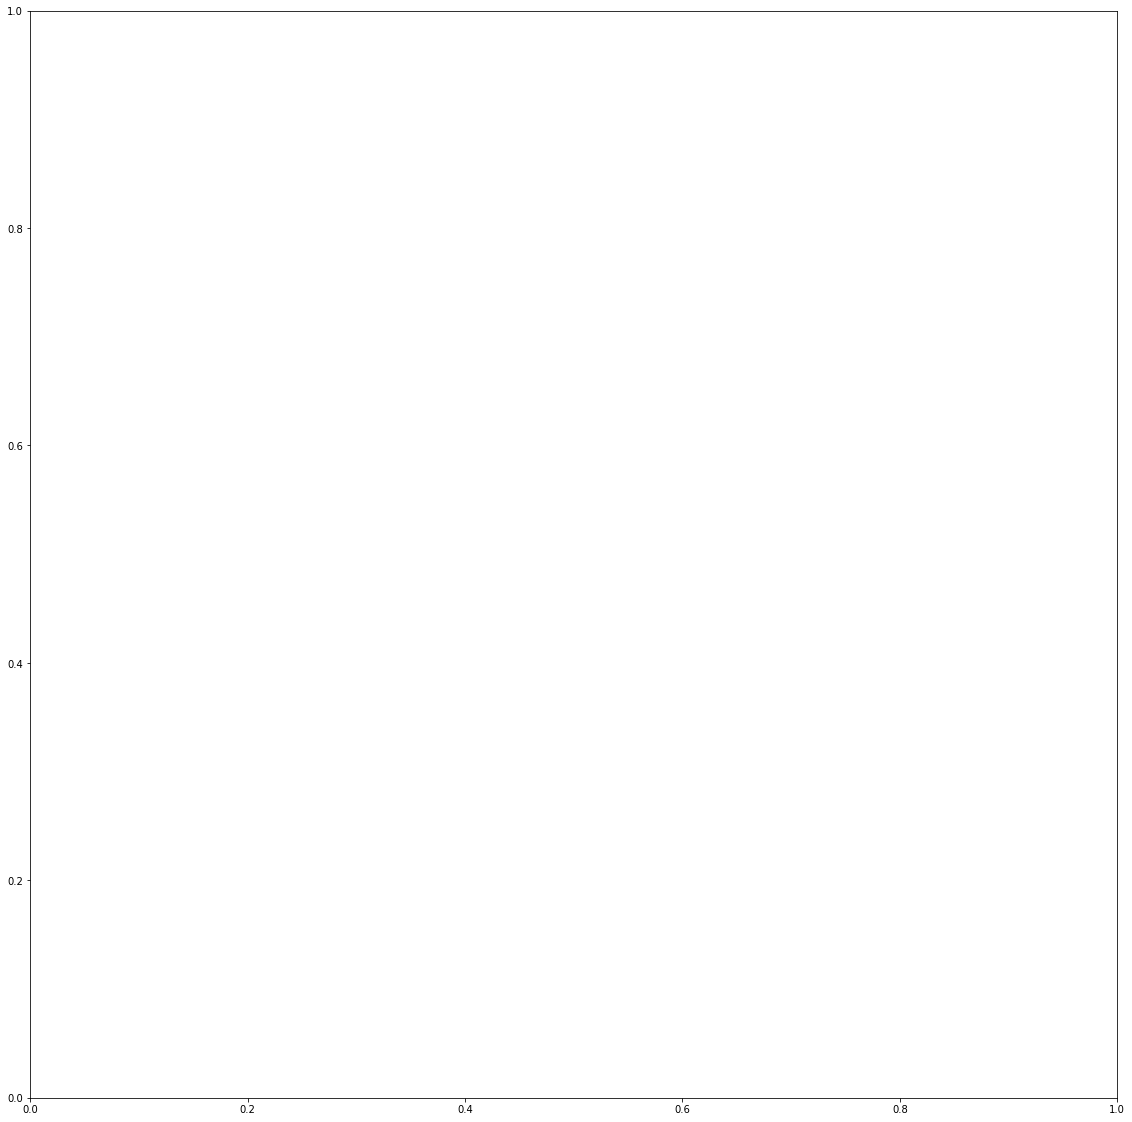

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import pickle

import numpy as np
import matplotlib.pyplot as plt

idx = 6
thrd = 2


# img_from_left =  plt.imread(os.path.join("/home/user/Logs/0902", 'EP0_from_left_940_1070_950_1040_mask.jpg'))
# img_from_right = plt.imread(os.path.join("/home/user/Logs/0902", 'EP0_from_right_940_1070_950_1040_mask.jpg'))
# img_from_up =    plt.imread(os.path.join("/home/user/Logs/0902", 'EP0_from_up_940_1070_950_1040_mask.jpg'))
# img_from_bot =   plt.imread(os.path.join("/home/user/Logs/0902", 'EP0_from_bot_940_1070_950_1040_mask.jpg'))

with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0902", 'EP0_from_left_940_1070_950_1040_mask.pkl'), 'rb') as f:
    img_from_left = pickle.load(f, encoding="latin1")
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0902", 'EP0_from_right_940_1070_950_1040_mask.pkl'), 'rb') as f:
    img_from_right = pickle.load(f, encoding="latin1")  
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0902", 'EP0_from_up_940_1070_950_1040_mask.pkl'), 'rb') as f:
    img_from_up = pickle.load(f, encoding="latin1")
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0902", 'EP0_from_bot_940_1070_950_1040_mask.pkl'), 'rb') as f:
    img_from_bot = pickle.load(f, encoding="latin1")    
with open(os.path.join("/home/user/Backup/DRL服务器备份/Logs/0902", 'EP0_all_940_1070_950_1040_mask.pkl'), 'rb') as f:
    img_all = pickle.load(f, encoding="latin1")   
    
with open(os.path.join("/home/user/Backup/DRL服务器备份/Projects/interaction_gyt", 'EP0_road_polygon.pkl'), 'rb') as f:
    road_polygons = pickle.load(f, encoding="latin1")   
        

fig, ax = plt.subplots(1,1, figsize=(20, 20))
ax.set_aspect('equal', adjustable='box')

filename = data['filename'][idx].split('/')[-1]

if filename[-6:-4] == "P0":
    use_img = img_EP0
    min_x, max_x, min_y, max_y = EP0_bds
elif filename[-6:-4] == "P1":
    use_img = img_EP1    
    min_x, max_x, min_y, max_y = EP1_bds
elif filename[-6:-4] == "GL":
    use_img = img_GL
    min_x, max_x, min_y, max_y = GL_bds
else:
    use_img = img_MA
    min_x, max_x, min_y, max_y = MA_bds

print(min_x, max_x, min_y, max_y)
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])




orig = data['orig'][idx]
rot = data['rot'][idx]
graph = data['graph'][idx]
    

gt_preds = data['gt_preds'][idx]
has_preds = data['has_preds'][idx]

off_road_count = 0
for k in range(1):
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     

#     ctrs = graph['ctrs']
#     nctrs = np.matmul(ctrs, rot) + orig
#     for i in range(graph['suc'][0]['u'].shape[0]):
#         ax.plot(nctrs[[graph['suc'][0]['u'][i], graph['suc'][0]['v'][i]], 0], nctrs[[graph['suc'][0]['u'][i], graph['suc'][0]['v'][i]], 1], 'k-')
    for lb in road_polygons:
        ax.plot(lb[:,0], lb[:,1], 'k-', alpha=0.15)

#     ax.patches = []

    for a in range(data['gt_preds'][idx].shape[0]):
#         if a in [2,5,6]:
#             continue
        if a in [0,2,4,5]:
            continue 
            
        mask = has_preds[a]
        gt_pred = gt_preds[a][mask]
        
        gt_hist = data['gt_hist'][idx][a].cpu().detach().numpy()
        
        traj_to_show, traj_interval_vel = interval(data, results, idx, a, k)
            
            
        origin_yaw = gt_hist[0, 2] % (2 * np.pi)
        
#         if np.pi / 4 <= origin_yaw and origin_yaw < np.pi * 3 / 4:
#             use_img = img_from_bot
#             tag = "bot"
#         elif np.pi * 3 / 4 <= origin_yaw and origin_yaw < np.pi * 5 / 4:
#             use_img = img_from_right
#             tag = "right"
#         elif np.pi * 5 / 4 <= origin_yaw and origin_yaw < np.pi * 7 / 4:
#             use_img = img_from_up
#             tag = "up"
#         else:
#             use_img = img_from_left 
#             tag = "left"
        
#         use_img = img_all

        plt.plot(traj_to_show[:,0], traj_to_show[:,1], color="deepskyblue", marker=".")        

        flag_off_road = False
        for t in range(traj_to_show.shape[0]):
            x, y, yaw, vx, vy = traj_to_show[t]
            x = min(max_x, max(x, min_x))
            y = min(max_y, max(y, min_y))
            
            grid_x, grid_y = int((x - min_x) / (max_x - min_x + 1) * use_img.shape[1]), int((max_y - y) / (max_y - min_y + 1) * use_img.shape[0])
            if use_img[grid_y, grid_x] != 0:
#                 print("tag from %s agt %d fail at time %d, pos %f, %f, value %d" %(tag, a, t, x, y, use_img[grid_y, grid_x]))
                plt.plot(traj_to_show[t,0], traj_to_show[t,1], 'r.')
                flag_off_road = True
        
        if flag_off_road:
            off_road_count += 1
            
        c = mpl.colors.ListedColormap(['lightgrey', 'white'])
        n = mpl.colors.Normalize(vmin=0,vmax=255)        
        plt.imshow(use_img, extent=[min_x, max_x, min_y, max_y], cmap=c, norm=n)

        plt.plot(gt_hist[:, 0], gt_hist[:, 1], color="yellow", marker=".")
#         print(tag)
    
        time_stamp = 70
        tmp = np.zeros([3])
        tmp[:2] = traj_to_show[time_stamp][:2]
        tmp[2] = traj_to_show[time_stamp][2]
        

        ms = tmp
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate_plot(ms, width, length), closed=True, zorder=20, edgecolor='black', alpha=0.7)
#         if a in [1,3]:
#             rect.set_color("red")
        ax.add_patch(rect)    
#         plt.text(tmp[0], tmp[1]+2, str(a), color="r", size="xx-large")
    
#     plt.savefig('/home/user/Logs/1102/' + str(idx) + '_GCN', dpi=400)
    plt.show()


In [ ]:
    
with open(os.path.join("/home/user/Projects/interaction_gyt", 'EP0_road_polygon.pkl'), 'rb') as f:
    road_polygons = pickle.load(f, encoding="latin1")   
        

'/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'

In [ ]:

# (data['gt_preds'][idx].shape[0])
idx = 2
k=0

In [7]:
%%time
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.colors as colors

def create_animation():
  """ Creates a Matplotlib animation of the given images."""

  plt.ioff()
  fig, ax = plt.subplots(1,1, figsize=(20, 20))

#   plt.gca().invert_xaxis()
#   plt.gca().invert_yaxis() 
    

  ax.set_aspect('equal', adjustable='box')
    
  plt.ion()
  
  graph = data['graph'][idx]
  rot = data['rot'][idx]
  orig = data['orig'][idx]
  ctrs = graph['ctrs']
  ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

  trajs_array_to_show = []
  for a in range(data['gt_preds'][idx].shape[0]):
    traj_to_show, traj_interval_vel = interval(data, results, idx, a, k)
    traj_plot(results[idx][a, 0, :, :], rot, orig, ax, 'b.')
#     traj_plot(traj_to_show, rot, orig, ax, 'b.')
    
    trajs_array_to_show.append(traj_to_show)
#     hist = data['feats'][idx][a][:,:2]
#     plt.plot(hist[:, 0], hist[:, 1], 'y.')
#     traj_plot(gt_preds[a],  rot, orig, ax, 'r.')
    
#     plt.plot(res_final_lane[a][:, 0], res_final_lane[a][:, 1], 'g', linewidth=5)
#     plt.scatter(res_final_pt[a][0], res_final_pt[a][1], s=150)
    

  def animate_func(time_stamp):
    ax.patches = []
    
#     for a in new_data['others_track'].keys():
    for a in range(len(trajs_array_to_show)):
        tmp = np.zeros([3])
        tmp[:2] = np.matmul(data['rot'][idx].cpu().detach().numpy(), (trajs_array_to_show[a][time_stamp][:2] - data['orig'][idx].cpu().detach().numpy()).T).T
        tmp[2] = trajs_array_to_show[a][time_stamp][2] + data['theta'][idx]
        
        ms = tmp
        rect = matplotlib.patches.Polygon(polygon_xy_from_motionstate_plot(ms, width, length), closed=True, zorder=20)
        ax.add_patch(rect)


  anim = animation.FuncAnimation(
      fig, animate_func, frames=20+config['pred_size'], interval=100)
  plt.close(fig)
    
  return anim

anim = create_animation()
HTML(anim.to_html5_video())

NameError: name 'plt' is not defined

In [ ]:
# results[idx][a, 0, :, :]

In [ ]:
origin_data['shape']

In [ ]:
torch.arange(prediction.shape[0])
prediction.get_device()

In [ ]:
from metrics import compute_joint_metrics
compute_joint_metrics(prediction, truth, [])

In [6]:
import csv
from tqdm import tqdm

csv_prefix = '/home/user/Downloads/collected_id_pair'
csv_folders = os.listdir(csv_prefix)

larger_than_5s = 0
files_5s = []

larger_than_8s = 0
files_8s = []

larger_than_10s = 0
files_10s = []

total_count = 0

for folder in tqdm(csv_folders):
    csv_path = os.path.join(csv_prefix, folder)
    for name in os.listdir(csv_path):
        csv_file = os.path.join(csv_path, name)
#         print(csv_file)

        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            for i in reader:
                total_count += 1
#                 print(i[3], i[4], i[5])
                if int(i[5]) - int(i[4]) > 5000:
                    larger_than_5s += 1
                    files_5s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 8000:
                    larger_than_8s += 1
                    files_8s.append([i[3:]])
                    
                if int(i[5]) - int(i[4]) > 10000:
                    larger_than_10s += 1
                    files_10s.append([i[3:]])


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Downloads/collected_id_pair'

In [5]:
# from cvxopt  import solvers, matrix
import numpy as np
from qpsolvers import solve_qp
from numpy import array, dot
import sympy as sym
import math 

class spline5:
    def __init__(self, Xseq, Yseq, yaw=None, Tseq=None, vx=None, vy=None):
        self.Xseq = Xseq
        self.Yseq = Yseq
        self.vx = vx 
        self.vy = vy 
        self.Tseq = Tseq if Tseq is not None else range(len(Xseq))
        
        self.T = config['pred_size']
        order = 6
        self.order = order
        
        if len(self.Tseq) == 1:
            return
        
        p = np.zeros([len(self.Tseq) * 2, (order + 1) * 2])
        q = np.zeros([len(self.Tseq) * 2, 1])
        for i in range(len(self.Tseq)):
            t = self.Tseq[i] / (self.T - 1)
            for j in range(order + 1):
                ttt = np.power(t, j)
                p[i][j] = ttt
                p[i + len(self.Tseq)][j + order + 1] = ttt
            q[i] = Xseq[i]
            q[i + len(self.Tseq)] = Yseq[i]

            
            
        bound = 2
###### -b <= d2y/d2x <= b
        g = np.zeros([len(self.Tseq) * 2, (order + 1) * 2])
        h = np.zeros([len(self.Tseq) * 2])
        for i in range(len(self.Tseq)):
            t = self.Tseq[i] / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g[i][j]                 = -bound * j * (j-1) * ttt
                g[i][j + order + 1]     = j * (j-1) * ttt            
                
                g[i + len(self.Tseq)][j]        = -bound * j * (j-1) * ttt
                g[i + len(self.Tseq)][j + order + 1] = -j * (j-1) * ttt
        

####### -b <= d2x/d2y <= b
        g2 = np.zeros([len(self.Tseq) * 2, (order + 1) * 2])
        h2 = np.zeros([len(self.Tseq) * 2])
        for i in range(len(self.Tseq)):
            t = self.Tseq[i] / (self.T - 1)
            
            for j in range(2, order + 1):
                ttt = np.power(t, j-2)
                g2[i][j]                      = j * (j-1) * ttt            
                g2[i][j + order + 1]          = -bound * j * (j-1) * ttt
                
                g2[i + len(self.Tseq)][j]             = -j * (j-1) * ttt
                g2[i + len(self.Tseq)][j + order + 1] = -bound * j * (j-1) * ttt
        

####### 
        


        
#         np.set_printoptions(precision=2)
#         print('p', p)
#         P = np.dot(p.T, p) + np.dot(g.T, g) * 0.001 + np.eye((order + 1) * 2) * 0.0001
        P = np.dot(p.T, p) + np.eye((order + 1) * 2) * 0.0001
        Q = -np.dot(q.T, p)
            
        Q = Q.reshape(((order + 1) * 2,))
        
        A = np.zeros([5, (order + 1) * 2])
        B = np.zeros([A.shape[0], 1])
        
        A[0][0] = 1
        A[1][order + 1] = 1
        B[0] = Xseq[0]
        B[1] = Yseq[0]
        
        if vx is not None and vy is not None:
            A[2][1] = 1
            B[2] = vx 
            A[3][1 + order + 1] = 1
            B[3] = vy 
            
        if yaw is not None:
            A[-1][1] = math.tan(yaw) 
            A[-1][1+order+1] = -1

            B[-1] = 0
            
        B = B.reshape((A.shape[0],))
        
        
        G = np.concatenate([g, g2])
        H = np.concatenate([h, h2])
                
#         self.sol = solve_qp(P=P, q=Q)
        self.sol = solve_qp(P=P, q=Q, A=A, b=B)
#         self.sol = solve_qp(P=P, q=Q, A=A, b=B, G=G, h=H)



    def cal(self, t):
        if len(self.Tseq) == 1:
            return self.Xseq[0], self.Yseq[0], 0, 0
            
        x = 0
        y = 0
        order = self.order
        dx = 0
        dy = 0
        
        if t >= 0 and t <= 1:
            for i in range(order + 1):
                ttt = np.power(t, i)
                x += self.sol[i] * ttt
                y += self.sol[i + order + 1] * ttt

            for i in range(1, order + 1):    
                ttt = np.power(t, i - 1)
                dx += self.sol[i] * i * ttt
                dy += self.sol[i + order + 1] * i * ttt
        
        return x, y, dx, dy 

    def plot_scatter(self):
        X, Y = [], []

        T = [i / (self.T - 1) for i in range(self.T)]
        for t in T:
            x, y, dx, dy = self.cal(t)
            X.append(x)
            Y.append(y)

            
        plt.scatter(T, X)
        plt.scatter([ts / (self.T - 1) for ts in (self.Tseq)], self.Xseq, color='red')
        plt.show()        
#     
        plt.scatter(T, Y)
        plt.scatter([ts / (self.T - 1) for ts in (self.Tseq)], self.Yseq, color='red')
        plt.show()

        plt.scatter(X, Y)
        plt.scatter(self.Xseq, self.Yseq, color='red')
        plt.show()

# sp = spline5(Xseq[::1], Yseq[::1])
# sp = spline5(Xseq=traj_interval_vel[:, 0], 
#                      Yseq=traj_interval_vel[:, 1],
#                      vx=np.cos(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10, 
#                      vy=np.sin(traj_interval_vel[:,2]) * traj_interval_vel[:,3] / 10)
# sp.cal(0)

In [ ]:
order = 5
np.diag([1 for i in range(order + 1)] + [0.1 for i in range(order + 1)])

In [ ]:
print(graph['suc'][0]['u'].shape)
print(graph['suc'][0]['u'])

In [ ]:
ego_id = 1
data['ctrs'][0][ego_id]

In [ ]:
graph.keys()
lane_id = graph['lane_idcs'][ego_graph_id]
print("start point ctr id", lane_id)

torch.nonzero(graph['lane_idcs']==lane_id)

In [4]:
def dfs(cur_graph_id, Lanes, lane, cur_len, S_pred, iter):
    graph_u = graph['suc'][0]['u']
    graph_v = graph['suc'][0]['v']
    
    suc_indices = (graph_u==cur_graph_id).nonzero()
    if cur_len > S_pred or suc_indices.shape[0] == 0 or iter > 100:
        Lanes.append(torch.stack(lane).long())
        print(cur_len, S_pred)
        print(Lanes[-1])
        return 
    
    for suc_id in suc_indices:
        lane.append(graph_v[suc_id[0]])
        
        s_diff = graph['ctrs'][graph_v[suc_id[0]]] - graph['ctrs'][graph_u[suc_id[0]]]
        s = torch.sqrt(torch.sum(s_diff ** 2))
#         print(s.numpy())
        dfs(graph_v[suc_id[0]], Lanes, lane, cur_len + s, S_pred, iter+1)
        lane.pop()

In [ ]:
Lanes = []
dfs(ego_graph_id, Lanes, [], 0, S_pred=100, iter=0)
frenet_lane = graph['ctrs'][Lanes[0]]
# print(frenet_lane)
# print(graph['ctrs'][ego_graph_id])

In [ ]:
ego_id = 1
k=3

pred = results[idx][ego_id][k]
diff = np.diff(pred, axis=0)
S_pred = np.sum(np.sqrt(np.sum(diff ** 2, axis=1)))

print(graph['ctrs'])
print(data['ctrs'][idx][ego_id, :])
map_car0 = graph['ctrs'] - data['ctrs'][idx][ego_id, :]
# map_car0 = graph['ctrs'] - torch.Tensor(np.array([990.57, 983.906]))
start = torch.sum(map_car0 ** 2, 1)

graph_u = graph['suc'][0]['u']
graph_v = graph['suc'][0]['v']

ego_graph_id = torch.argmin(start)
# ego_graph_id = 1281

print(ego_graph_id)
graph['ctrs'][ego_graph_id]
gt_preds.shape

fig, ax = plt.subplots(1,1, figsize=(40,40))
ax.set_aspect('equal', adjustable='box')
#     plt.gca().invert_xaxis()
#     plt.gca().invert_yaxis()     
# for a in range(data['gt_preds'][idx].shape[0]):
#     mask = has_preds[a]
#     gt_pred = gt_preds[a][mask]

#     hist = data['feats'][idx][a]
# #     plt.plot(hist[:, 0], hist[:, 1], 'y.')
# #     traj_plot(gt_pred,  rot, orig, ax, 'r.')

#     pred_traj = results[idx][a, k, :, :]
traj_plot(results[idx][ego_id][k], rot, orig, ax, 'b.')
    
traj_plot(gt_preds[ego_id],  rot, orig, ax, 'r.')


ctrs = graph['ctrs']
ax.plot(ctrs[:, 0], ctrs[:, 1], 'k.')

Lanes = []
dfs(ego_graph_id, Lanes, [], 0, S_pred, iter=0)
for Lane in Lanes:
    frenet_lane = graph['ctrs'][Lane]
    ax.plot(frenet_lane[:, 0], frenet_lane[:, 1], 'g*')
ax.plot([graph['ctrs'][ego_graph_id][0]], [graph['ctrs'][ego_graph_id][1]], 'r*')


plt.show()